# Bitcoin Price Forecasting using ARIMA & LSTM

This project forecasts Bitcoin closing prices using:
- ARIMA (statistical time-series model)
- LSTM (deep learning model)

The goal is to compare traditional and deep learning approaches on the same dataset
and build an interview-ready, deployable solution.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import joblib
import warnings

f:\Crypto-price-forcast\venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [3]:
import yfinance as yf

df = yf.download('BTC-USD', start='2010-01-01')


[*********************100%***********************]  1 of 1 completed


In [4]:
df.head()

Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2014-09-17,457.334015,468.174011,452.421997,465.864014,21056800
2014-09-18,424.440002,456.859985,413.104004,456.859985,34483200
2014-09-19,394.795990,427.834991,384.532013,424.102997,37919700
2014-09-20,408.903992,423.295990,389.882996,394.673004,36863600
2014-09-21,398.821014,412.425995,393.181000,408.084991,26580100


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4131 entries, 2014-09-17 to 2026-01-07
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Close, BTC-USD)   4131 non-null   float64
 1   (High, BTC-USD)    4131 non-null   float64
 2   (Low, BTC-USD)     4131 non-null   float64
 3   (Open, BTC-USD)    4131 non-null   float64
 4   (Volume, BTC-USD)  4131 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 193.6 KB


In [6]:
df.describe()

Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
count,4131.000000,4131.000000,4131.000000,4131.000000,4.131000e+03
mean,26957.805161,27478.415495,26365.640596,26936.699780,2.166056e+10
std,31735.250036,32264.996156,31146.702577,31722.556707,2.288574e+10
min,178.102997,211.731003,171.509995,176.897003,5.914570e+06
25%,2713.844971,2782.045044,2643.605103,2708.385010,1.315450e+09
50%,10784.491211,11046.700195,10479.099609,10795.254883,1.711059e+10
75%,42279.095703,43139.138672,41445.703125,42270.767578,3.320588e+10
max,124752.531250,126198.070312,123196.046875,124752.140625,3.509679e+11


In [7]:
df.isnull().sum()

Price   Ticker 
Close   BTC-USD    0
High    BTC-USD    0
Low     BTC-USD    0
Open    BTC-USD    0
Volume  BTC-USD    0
dtype: int64

In [8]:
df.columns = df.columns.get_level_values(0)

df = df[['Close']]
print(df.head())
print(df.describe())

Price            Close
Date                  
2014-09-17  457.334015
2014-09-18  424.440002
2014-09-19  394.795990
2014-09-20  408.903992
2014-09-21  398.821014
Price          Close
count    4131.000000
mean    26957.805161
std     31735.250036
min       178.102997
25%      2713.844971
50%     10784.491211
75%     42279.095703
max    124752.531250


### Outlier Detection (Boxplot)
The boxplot shows multiple high-value outliers in Bitcoin closing prices.
These outliers correspond to real market events such as bull runs and high volatility periods.
Outliers were analyzed but not removed to preserve true market behavior.

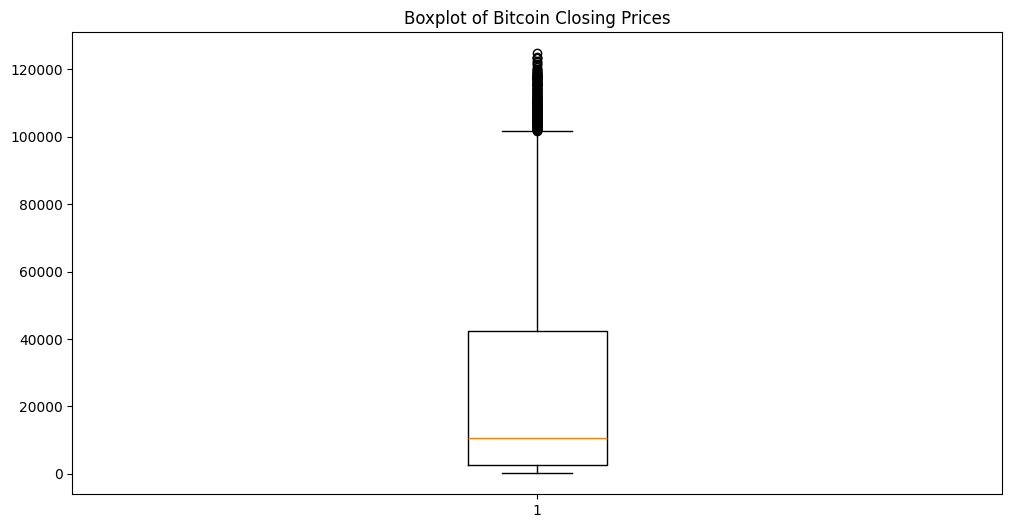

In [9]:
plt.figure(figsize=(12,6))
plt.boxplot(df['Close'])
plt.title('Boxplot of Bitcoin Closing Prices')
plt.show()

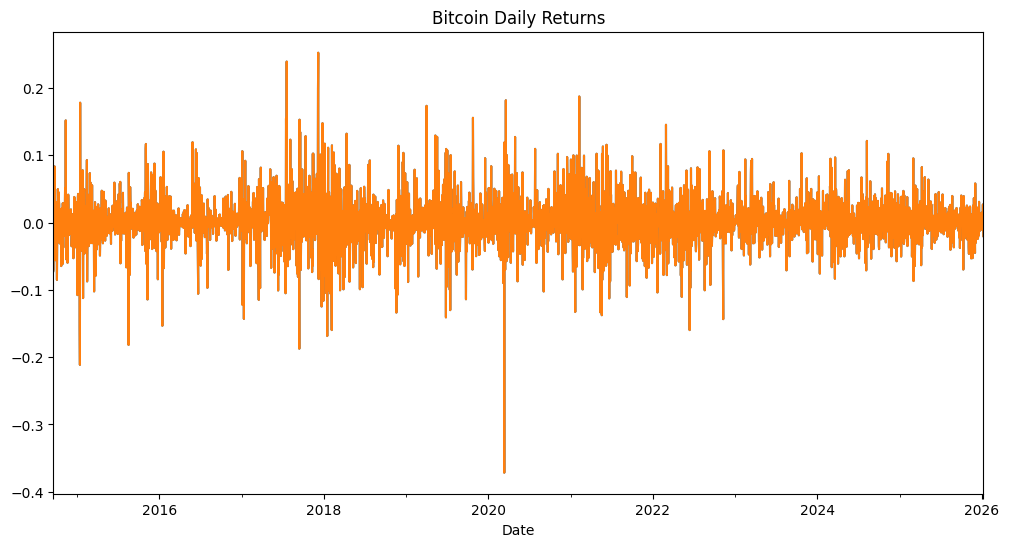

In [10]:
df['return'] = df['Close'].pct_change()
df['return'].dropna().plot(figsize=(12,6))
plt.plot(df.index, df['return'])
plt.title('Bitcoin Daily Returns')
plt.show()

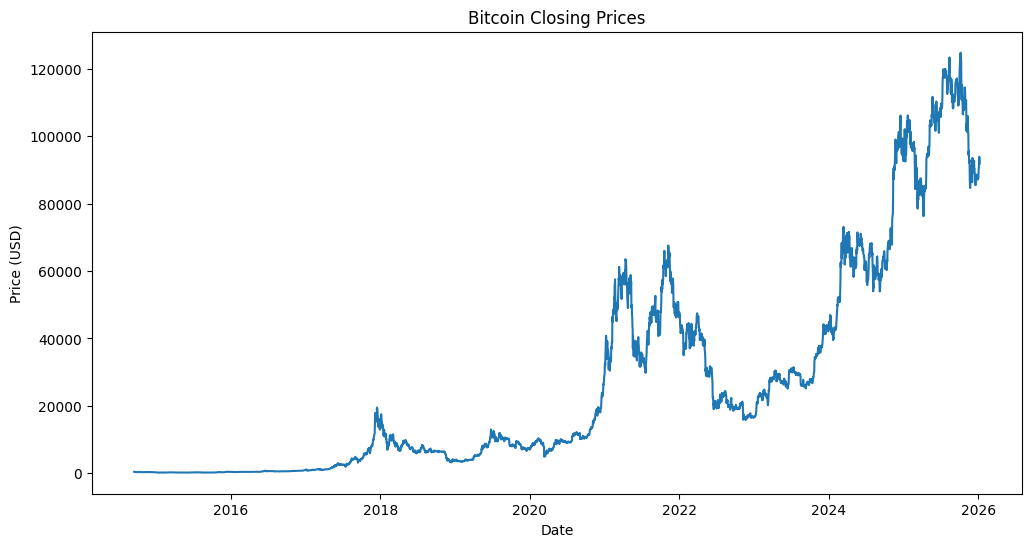

In [11]:
plt.figure(figsize=(12,6))
plt.plot(df['Close'])
plt.title('Bitcoin Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.show()

In [12]:
results = adfuller(df['Close'])
print('ADF Statistic:', results[0]) 
print('p-value:', results[1])

ADF Statistic: -0.6649639728938139
p-value: 0.8556171739995654


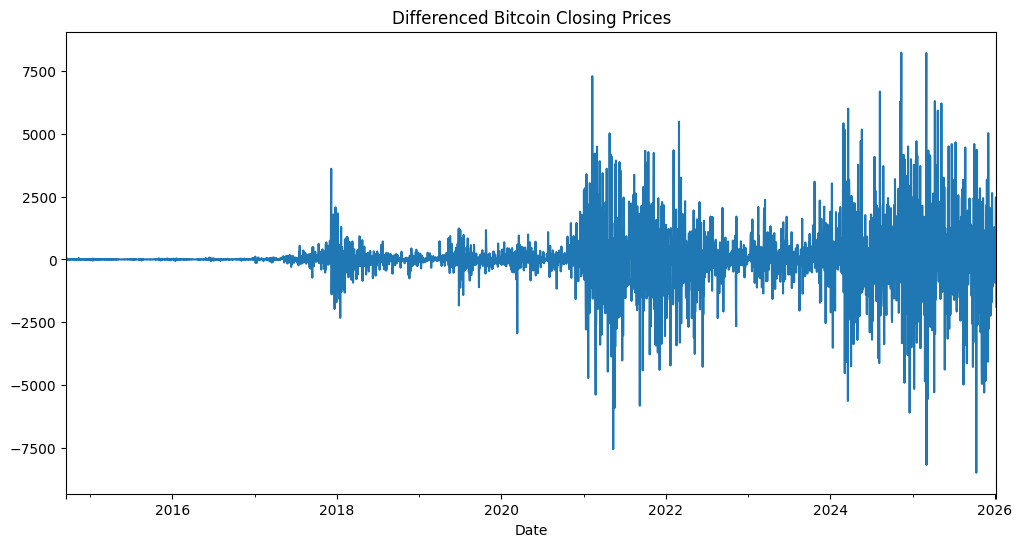

In [13]:
df['Close_diff'] = df['Close'].diff()
df['Close_diff'].dropna().plot(figsize=(12,6))
plt.title('Differenced Bitcoin Closing Prices')
plt.xlabel('Date')      
plt.show()

In [14]:
train_size = int(len(df) * 0.8)
train, test = df['Close'][:train_size], df['Close'][train_size:]

In [31]:
arima_model = ARIMA(train, order=(5,1,2), enforce_stationarity=False, enforce_invertibility=False)
arima_result = arima_model.fit()
print(arima_result.summary())

f:\Crypto-price-forcast\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
f:\Crypto-price-forcast\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
f:\Crypto-price-forcast\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3304
Model:                 ARIMA(5, 1, 2)   Log Likelihood              -26637.967
Date:                Wed, 07 Jan 2026   AIC                          53291.935
Time:                        19:04:14   BIC                          53340.743
Sample:                    09-17-2014   HQIC                         53309.407
                         - 10-03-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1195      1.870     -0.064      0.949      -3.785       3.546
ar.L2          0.1805      0.440      0.410      0.682      -0.683       1.044
ar.L3          0.0252      0.027      0.943      0.3

In [32]:
arima_forecast = arima_result.forecast(steps=len(test))

In [33]:
arima_rmse = np.sqrt(mean_squared_error(test, arima_forecast))
arima_mae = mean_absolute_error(test, arima_forecast)

print(f'ARIMA RMSE: {arima_rmse}')
print(f'ARIMA MAE: {arima_mae}')

ARIMA RMSE: 57332.14043158761
ARIMA MAE: 51304.95300830753


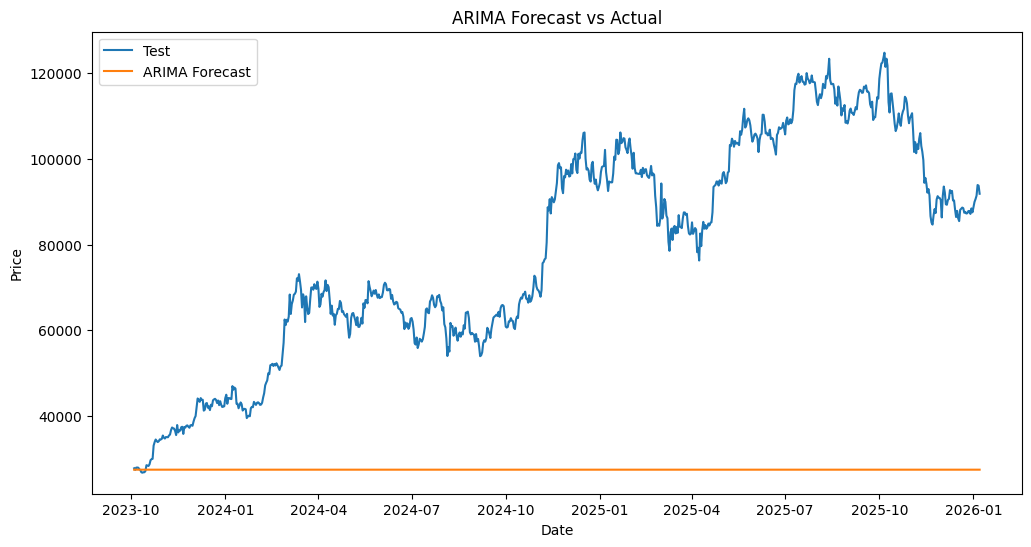

In [34]:
plt.figure(figsize=(12,6))
plt.plot(test.index, test, label='Test')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast')
plt.legend()
plt.title('ARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

LSTM Modeling

In [35]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Close']])

In [36]:
def create_sequences(data, windows = 60):
    X, y = [], []
    for i in range(windows, len(data)):
        X.append(data[i-windows:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data)

In [37]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [38]:
lstm_model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=1)
])

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.summary()

f:\Crypto-price-forcast\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
history = lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 0.0026 - val_loss: 1.0293e-04
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.6580e-04 - val_loss: 9.1901e-05
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.6392e-04 - val_loss: 9.3483e-05
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.1966e-04 - val_loss: 8.3143e-05
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.8443e-04 - val_loss: 9.5514e-05
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.7333e-04 - val_loss: 8.0979e-05
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.3375e-04 - val_loss: 1.8025e-04
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.3743e-04 - val_loss: 8.0127e-05
Epoch 9/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.9165e-04 - val_loss: 9.3329e-05
Epoch 10/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.8574e-04 - val_loss: 9.9432e-05
Epoch 11/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.0529e-04 - 

In [40]:
lstm_predictions = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


In [41]:
lstm_rmse = np.sqrt(mean_squared_error(y_test_actual, lstm_predictions))
lstm_mae = mean_absolute_error(y_test_actual, lstm_predictions)
print(f'LSTM RMSE: {lstm_rmse}')
print(f'LSTM MAE: {lstm_mae}')

LSTM RMSE: 2938.573285517951
LSTM MAE: 2245.4797929447855


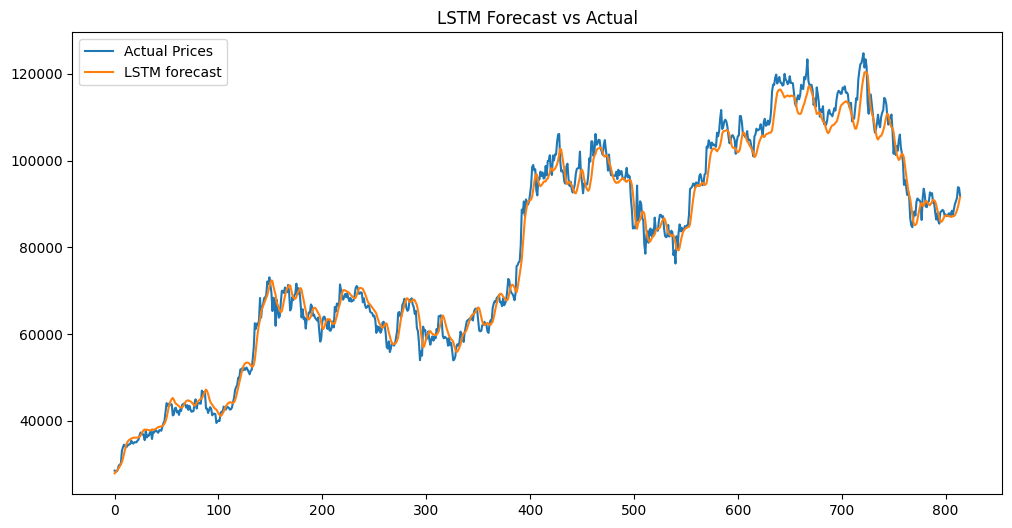

In [42]:
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label='Actual Prices')
plt.plot(lstm_predictions, label='LSTM forecast')
plt.title('LSTM Forecast vs Actual')
plt.legend()
plt.show()

In [43]:
future_steps = 30
future_forecast = arima_result.forecast(steps=future_steps)

future_dates = pd.date_range(start=df.index[-1], periods=future_steps + 1, freq='D')[1:]

future_df = pd.DataFrame(future_forecast.values, index=future_dates, columns=['Forecast'])

future_df.head()

,Forecast
2026-01-08,27453.885075
2026-01-09,27477.725174
2026-01-10,27468.275435
2026-01-11,27467.807767
2026-01-12,27466.877779


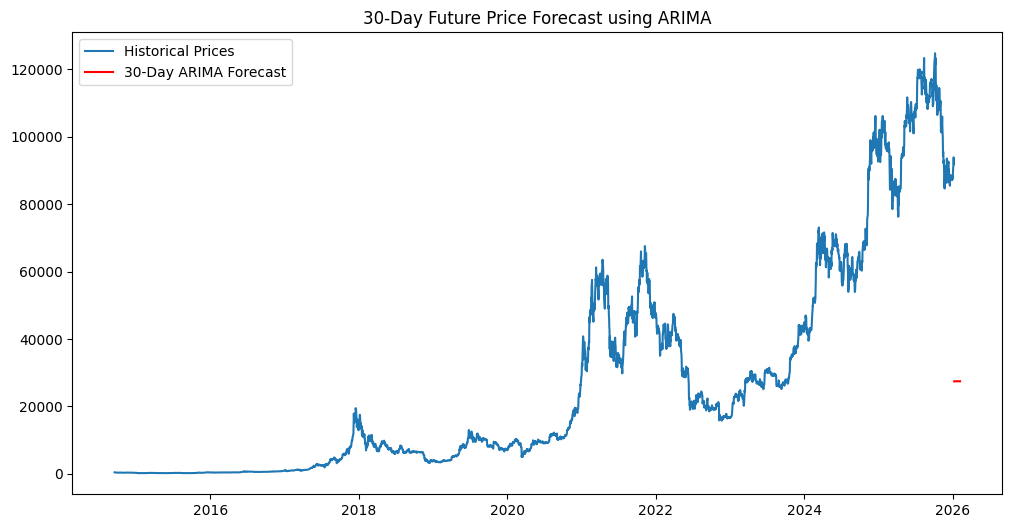

In [44]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Close'], label='Historical Prices')
plt.plot(future_df.index, future_df['Forecast'], label='30-Day ARIMA Forecast', color='red')
plt.title('30-Day Future Price Forecast using ARIMA')
plt.legend()
plt.show()

In [45]:
joblib.dump(arima_result, 'arima_model.pkl')
print("ARIMA model saved as 'arima_model.pkl'")

ARIMA model saved as 'arima_model.pkl'


In [46]:
lstm_model.save('lstm_model.h5')
print("LSTM model saved as 'lstm_model.h5'")

LSTM model saved as 'lstm_model.h5'


In [47]:
comparison_df = pd.DataFrame({
    "Model": ["ARIMA", "LSTM"],
    "RMSE": [arima_rmse, lstm_rmse],
    "MAE": [arima_mae, lstm_mae]
})
comparison_df

,Model,RMSE,MAE
0,ARIMA,57332.140432,51304.953008
1,LSTM,2938.573286,2245.479793


In [48]:
comparison_df.to_csv('model_comparison.csv', index=False)

In [49]:
df.to_csv('processed_crypto_data.csv', index=True)

In [50]:
df.to_pickle('processed_crypto_data.pkl')

In [51]:
df.head()

Price,Close,return,Close_diff
Date,,,
2014-09-17,457.334015,NaN,NaN
2014-09-18,424.440002,-0.071926,-32.894012
2014-09-19,394.795990,-0.069843,-29.644012
2014-09-20,408.903992,0.035735,14.108002
2014-09-21,398.821014,-0.024659,-10.082977
